In [296]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
import numpy as np
import matplotlib.pyplot as plt

## 1) Loading in the mortality data
#### TODO Is grouping them by country and getting the mean the way to go? Do we simply take the latest 5 years? need more looking into

In [141]:
data=pd.read_csv("Data/adult_mortality_by_country.csv",header=1)
mortality=data.drop(columns=['Male','Female'])
mortality=mortality.rename(columns={"Both sexes": "mortality_rate"})
mortality['mortality_rate'].describe()
mortality['Year']=pd.to_datetime(mortality['Year'],format='%Y')
mortality=mortality.groupby(['Country']).mean()
mortality.describe()

,mortality_rate
count,183.000000
mean,193.530376
std,109.179405
min,59.117647
25%,110.264706
50%,164.882353
75%,252.294118
max,549.352941


##  Visualizing outliers

#### The outliers in the outliers are not real outliers rather variance, apparently some countries really have that high of a mortality rate

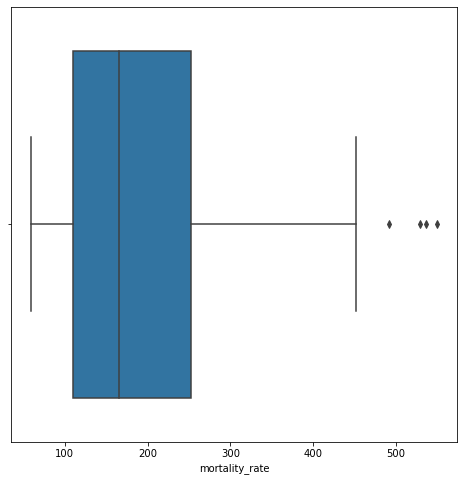

In [142]:
fig, ax= pyplot.subplots(figsize=(8,8))
sns.boxplot(x="mortality_rate", data=mortality, ax=ax)

In [143]:
mortality.loc[mortality["mortality_rate"]>300]

,mortality_rate
Country,
Botswana,431.294118
Burundi,334.941176
Cameroon,375.176471
Central African Republic,491.647059
Chad,391.470588
Congo,341.470588
Côte d'Ivoire,437.117647
Equatorial Guinea,341.588235
Eritrea,322.000000


## Defining Low and High mortality rate
#### TODO- SHOULD DOUBLE CHECK WHAT IS HIGH AND LOW MORTALITY. FOR NOW CHOSE ACCORDING TO THE QUARTILES

In [144]:
mortality['mortality_rate'] = np.where(mortality['mortality_rate'] <150, 'low', 'high')
mortality.head(15)                                                             

,mortality_rate
Country,
Afghanistan,high
Albania,low
Algeria,low
Angola,high
Antigua and Barbuda,low
Argentina,low
Armenia,low
Australia,low
Austria,low


#### View number of countries with low and high mortality rate

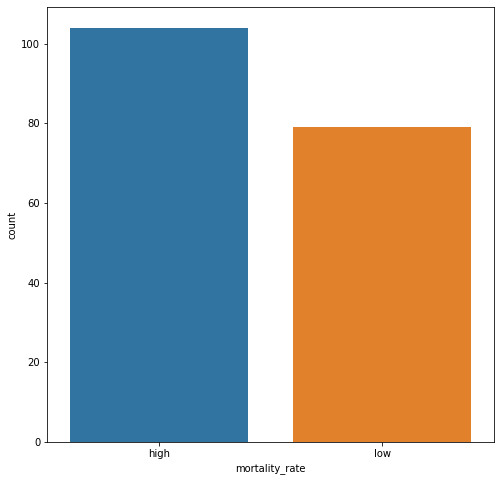

In [145]:
fig, ax= pyplot.subplots(figsize=(8,8))
sns.countplot(x=mortality['mortality_rate'],ax=ax)

## 2) Loading in the doctor data
#### TODO Is grouping them by country and getting the mean the way to go? Do we simply take the latest 5 years? need more looking into

In [146]:
data=pd.read_csv("Data/medical_doctors.csv")
doctors=data.drop(data.columns[[3,4,5,6]], axis=1)
doctors['Year']=pd.to_datetime(doctors['Year'],format='%Y')
doctors=doctors.rename(columns={"Medical doctors (per 10 000 population)": "medical_doctors"})
doctors=doctors.groupby(['Country']).mean()

#### By merging as below, we take the union of both dataframes therefore we're eliminating some rows which don't exist in the other

In [147]:
merged_data = pd.merge(left=mortality, right=doctors, left_on='Country', right_on='Country')
merged_data.head(5)

,mortality_rate,medical_doctors
Country,,
Afghanistan,high,2.322167
Albania,low,13.092864
Algeria,low,14.450000
Angola,high,1.168000
Antigua and Barbuda,low,13.394500


## 3) Loading in the hospital bed data

In [148]:
data=pd.read_csv("Data/hospital_bed_density.csv")
hospital_beds=data
hospital_beds['Year']=pd.to_datetime(hospital_beds['Year'],format='%Y')
hospital_beds=hospital_beds.rename(columns={"Hospital beds (per 10 000 population)": "hospital_beds"})
hospital_beds=hospital_beds.groupby(['Country']).mean()

In [149]:
merged_data= pd.merge(left=merged_data, right=hospital_beds, left_on='Country', right_on='Country')
merged_data

,mortality_rate,medical_doctors,hospital_beds
Country,,,
Afghanistan,high,2.322167,4.322222
Albania,low,13.092864,30.523077
Algeria,low,14.450000,18.000000
Angola,high,1.168000,8.000000
Antigua and Barbuda,low,13.394500,30.983333
...,...,...,...
Venezuela (Bolivarian Republic of),high,19.475000,8.340000
Viet Nam,low,6.880167,26.925000
Yemen,high,3.481600,6.672222


## 4) Viewing correlation of data

In [150]:
df=pd.get_dummies(merged_data['mortality_rate'])
df_corr = pd.concat([merged_data, df], axis=1)
df_corr.head(2)

,mortality_rate,medical_doctors,hospital_beds,high,low
Country,,,,,
Afghanistan,high,2.322167,4.322222,1,0
Albania,low,13.092864,30.523077,0,1


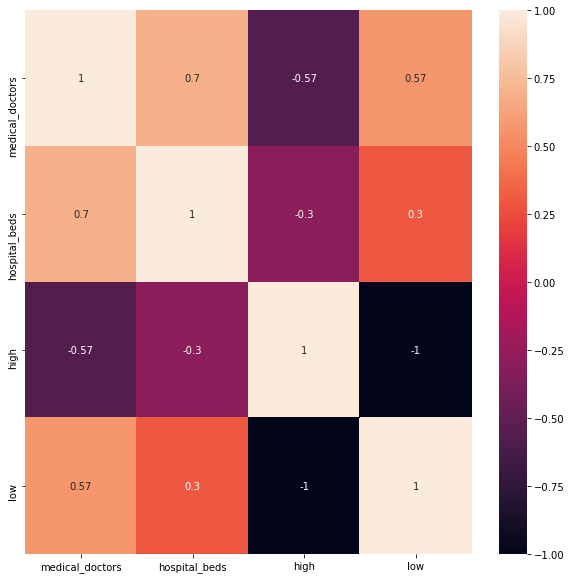

In [151]:
fig, ax= pyplot.subplots(figsize=(10,10))
sns.heatmap(df_corr.corr(),annot=True)

## 5) Creating the models

#### Splitting the data into training and testing

In [152]:
from sklearn.model_selection import train_test_split
merged_data=merged_data.reset_index()
feature_columns=['hospital_beds','medical_doctors']
X=merged_data[feature_columns]
y=merged_data.mortality_rate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

###  Training and performing the predictions using different models ( We can see that it overfits on some since the training accuracy is 1)

###### Decision tree

In [277]:
from sklearn import tree
from sklearn import metrics
clf = tree.DecisionTreeClassifier(criterion="gini",splitter='best',max_depth=6,min_samples_split=15)
clf = clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

print("Test accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Training accuracy:",clf.score(X_train,y_train))

Test accuracy: 0.7962962962962963
Training accuracy: 0.8870967741935484


In [278]:
#Method to find the optimal max_depth
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.model_selection import GridSearchCV



parameters = {'max_depth':range(3,20)}
clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
clf.fit(X=X_train, y=y_train)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 

0.7826666666666667 {'max_depth': 6}


#####  Random Forest

In [301]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=20,max_depth=4,min_samples_leaf=4) # https://intellipaat.com/community/9495/how-do-i-solve-overfitting-in-random-forest-of-python-sklearn
clf = clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

print("Test accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Training accuracy:",clf.score(X_train,y_train))





Test accuracy: 0.8333333333333334
Training accuracy: 0.8870967741935484


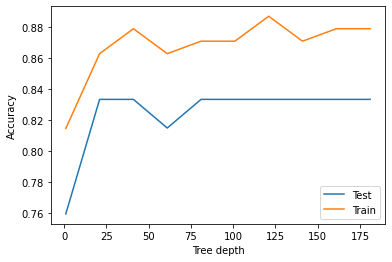

In [315]:
#viewing optimal estimator
train_result=[]
test_result=[]
estimators=[]
for n in range (1,200,20):
    clf = RandomForestClassifier(n_estimators=n,max_depth=4,min_samples_leaf=4) # https://intellipaat.com/community/9495/how-do-i-solve-overfitting-in-random-forest-of-python-sklearn
    clf = clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    estimators.append(n)
    test_result.append(metrics.accuracy_score(y_test, y_pred))
    train_result.append(clf.score(X_train,y_train))
line1,=plt.plot(estimators, test_result, label="Test")
line2,=plt.plot(estimators, train_result, label="Train")
plt.legend(handles=[line1, line2])
plt.ylabel('Accuracy')
plt.xlabel('Tree depth')
plt.show()

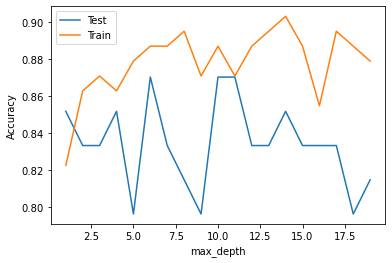

In [318]:
#viewing optimal max_depth
train_result=[]
test_result=[]
estimators=[]
for n in range (1,20,1):
    clf = RandomForestClassifier(n_estimators=20,max_depth=n,min_samples_leaf=4) # https://intellipaat.com/community/9495/how-do-i-solve-overfitting-in-random-forest-of-python-sklearn
    clf = clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    estimators.append(n)
    test_result.append(metrics.accuracy_score(y_test, y_pred))
    train_result.append(clf.score(X_train,y_train))
line1,=plt.plot(estimators, test_result, label="Test")
line2,=plt.plot(estimators, train_result, label="Train")
plt.legend(handles=[line1, line2])
plt.ylabel('Accuracy')
plt.xlabel('max_depth')
plt.show()

#### Ada boost

In [205]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()
clf = clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

print("Test accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Training accuracy:",clf.score(X_train,y_train))

Test accuracy: 0.7962962962962963
Training accuracy: 0.9758064516129032


#### Bagging classifier

In [209]:
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier()
clf = clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

print("Test accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Training accuracy:",clf.score(X_train,y_train))

Test accuracy: 0.7962962962962963
Training accuracy: 1.0
